In [1]:
#pip install adversarial-robustness-toolbox
#pip install tensorflow-gpu==1.12.0
#介绍ART平台如何攻击针对mnist的CNN/MLP分类模型
#参考https://github.com/IBM/adversarial-robustness-toolbox/blob/master/examples/mnist_cnn_fgsm.py

In [2]:
import sys
from os.path import abspath

import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np

from art.attacks.fast_gradient import FastGradientMethod
from art.classifiers import KerasClassifier
from art.utils import load_dataset

Using TensorFlow backend.


In [3]:
# Read MNIST dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str('mnist'))

# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
k.set_learning_phase(1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [4]:
classifier = KerasClassifier((min_, max_), model=model)
classifier.fit(x_train, y_train, nb_epochs=5, batch_size=128)

# Evaluate the classifier on the test set
preds = np.argmax(classifier.predict(x_test), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("\nTest accuracy: %.2f%%" % (acc * 100))

# Craft adversarial samples with FGSM
epsilon = .3  # Maximum perturbation
adv_crafter = FastGradientMethod(classifier)
x_test_adv = adv_crafter.generate(x=x_test, eps=epsilon)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(classifier.predict(x_test_adv), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("\nTest accuracy on adversarial sample: %.2f%%" % (acc * 100))

Epoch 1/5
469/468 [==============================] - 7s 16ms/step - loss: 0.2337 - acc: 0.9284
Epoch 2/5
469/468 [==============================] - 5s 11ms/step - loss: 0.0803 - acc: 0.9761
Epoch 3/5
469/468 [==============================] - 5s 11ms/step - loss: 0.0603 - acc: 0.9815
Epoch 4/5
469/468 [==============================] - 5s 11ms/step - loss: 0.0509 - acc: 0.9844
Epoch 5/5
469/468 [==============================] - 5s 11ms/step - loss: 0.0425 - acc: 0.9868

Test accuracy: 98.15%

Test accuracy on adversarial sample: 28.10%


In [5]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_correct_original = []


for eps in eps_range:
    x_test_adv = adv_crafter.generate(x_test, eps=eps)
    
    x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
    nb_correct_original += [np.sum(x_test_adv_pred == np.argmax(y_test, axis=1))/y_test.shape[0]]
        

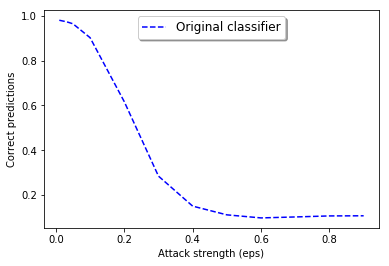

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(nb_correct_original), 'b--', label='Original classifier')
#ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Correct predictions')
plt.show()